In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Enter your path here which contains directories named ADHD_part1 and so on and so forth, the /content is path on my setup
PATH = "/content/drive/MyDrive/Archive/"

In [6]:
ADHD_directories = ["ADHD_part1","ADHD_part2"]
NonADHD_directories = ["Control_part1","Control_part2"]

In [7]:
import os
import scipy.io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
def get_params(data):  
  # Define sampling frequency and time vector
  sf = 128.
  time = np.arange(data.size) / sf
  return sf,time


In [9]:
from scipy import signal

def get_welch_params(data,sf):
# Define window length (4 seconds)
  win = 4 * sf
  freqs, psd = signal.welch(data, sf, nperseg=win)
  return freqs, psd

In [10]:
from scipy.integrate import simps
def get_absolute_power(psd,freqs,idx):
  freq_res = freqs[1] - freqs[0] 
  # Compute the absolute power by approximating the area under the curve
  power = simps(psd[idx],dx=freq_res)
  return power

In [11]:
def get_relative_power(psd,freqs,power):
  freq_res = freqs[1] - freqs[0]
  total_power = simps(psd, dx=freq_res)
  rel_power = power / total_power
  return rel_power

In [12]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp


In [13]:
def get_ratio(data,sf):
  win_sec = 4

  # Delta/beta ratio based on the absolute power
  db = bandpower(data, sf, [0.5, 4], win_sec) / bandpower(data, sf, [12, 30], win_sec)

  # Delta/beta ratio based on the relative power
  db_rel = bandpower(data, sf, [0.5, 4], win_sec, True) / bandpower(data, sf, [12, 30], win_sec, True)

  

In [14]:
channel_dict = {'Fp1':0,'Fp2':1,'F3':2,'F4':3,'C3':4,'C4':5,'P3':6,'P4':7,'O1':8,'O2':9,'F7':10,'F8':11,'T7':12,'T8':13,'P7':14,'P8':15,'Fz':16,'Cz':17,'Pz':18}	


In [15]:
bands = {'alpha':[8,12],'beta':[12,30],'theta':[4,8],'delta':[0.5,4]}


In [16]:
def get_band_indexes(low,high,freqs):
  idx = np.logical_and(freqs >= low, freqs <= high)
  return idx
  

In [17]:
#Considering all channels and generating ratios for all channels now
for channel_name in channel_dict:
#Change the channel name here whichever data or ratios needed
  #Dataframe to store absolute bandpower
  dataframe_bands = pd.DataFrame()
  for directory in ADHD_directories: 
    for mat_file in os.listdir(os.path.join(PATH,directory)):
      #loading the file
      if ".mat" in mat_file:
        loaded_file = scipy.io.loadmat(os.path.join(PATH,directory,mat_file))
      #getting data from the loaded file, mat_file[:-4] gives name of file without .mat
        per_person_data = loaded_file[mat_file[:-4]]
      #Get the exact column information
        data = per_person_data[:,channel_dict[channel_name]]
        sf,time = get_params(data)
        freqs,psd = get_welch_params(data,sf)
      #add alpha ,beta,theta and delta info one by one
        idx_alpha = get_band_indexes(bands['alpha'][0],bands['alpha'][1],freqs)
        alpha = get_absolute_power(psd,freqs,idx_alpha)
        rel_alpha = get_relative_power(psd,freqs,alpha)
        idx_beta = get_band_indexes(bands['beta'][0],bands['beta'][1],freqs)
        beta = get_absolute_power(psd,freqs,idx_beta)
        rel_beta = get_relative_power(psd,freqs,beta)
        idx_theta = get_band_indexes(bands['theta'][0],bands['theta'][1],freqs)
        theta = get_absolute_power(psd,freqs,idx_theta)
        rel_theta = get_relative_power(psd,freqs,theta)
        idx_delta = get_band_indexes(bands['delta'][0],bands['delta'][1],freqs)
        delta = get_absolute_power(psd,freqs,idx_delta)
        rel_delta = get_relative_power(psd,freqs,delta)
        dataframe_bands = dataframe_bands.append({'Filename' : mat_file,'Label': 'ADHD', 'Absolute_Alpha':alpha,'Relative_Alpha':rel_alpha,'Absolute_Beta':beta,'Relative_Beta':rel_beta,'Absolute_Theta':theta,'Relative_Theta':rel_theta,'Absolute_Delta':delta,'Relative_Delta':rel_delta},ignore_index=True)

  for directory in NonADHD_directories:
    for mat_file in os.listdir(os.path.join(PATH,directory)):
      loaded_file = scipy.io.loadmat(os.path.join(PATH,directory,mat_file))
      if ".mat" in mat_file:
        per_person_data = loaded_file[mat_file[:-4]]
        #Get the exact column information
        data = per_person_data[:,channel_dict[channel_name]]
        sf,time = get_params(data)
        freqs,psd = get_welch_params(data,sf)
        #add alpha ,beta,theta and delta info one by one
        idx_alpha = get_band_indexes(bands['alpha'][0],bands['alpha'][1],freqs)
        alpha = get_absolute_power(psd,freqs,idx_alpha)
        rel_alpha = get_relative_power(psd,freqs,alpha)
        idx_beta = get_band_indexes(bands['beta'][0],bands['beta'][1],freqs)
        beta = get_absolute_power(psd,freqs,idx_beta)
        rel_beta = get_relative_power(psd,freqs,beta)
        idx_theta = get_band_indexes(bands['theta'][0],bands['theta'][1],freqs)
        theta = get_absolute_power(psd,freqs,idx_theta)
        rel_theta = get_relative_power(psd,freqs,theta)
        idx_delta = get_band_indexes(bands['delta'][0],bands['delta'][1],freqs)
        delta = get_absolute_power(psd,freqs,idx_delta)
        rel_delta = get_relative_power(psd,freqs,delta)
        dataframe_bands = dataframe_bands.append({'Filename' : mat_file,'Label': 'Non_ADHD', 'Absolute_Alpha':alpha,'Relative_Alpha':rel_alpha,'Absolute_Beta':beta,'Relative_Beta':rel_beta,'Absolute_Theta':theta,'Relative_Theta':rel_theta,'Absolute_Delta':delta,'Relative_Delta':rel_delta},ignore_index=True)
  dataframe_bands.to_csv('/content/'+channel_name+'.csv')


In [18]:
#Pass nominator and denominator as whose ratio needed
#Example Theta to Beta ratio 
#For above example check column names in csv for the channel 
#It is Absolute_Theta and Absolute_Beta
#So, call function with get_ratio("Absolute_Theta","Absolute_Beta","Cz")
def get_ratio_c(nominator,denominator,channel_name):
  band_data = pd.read_csv("/content/" + channel_name + ".csv")
  nominator_array = np.array(band_data[nominator])
  denominator_array = np.array(band_data[denominator])
  ratios = nominator_array/denominator_array
  
  labels = band_data['Label']
  del band_data
  return np.array(ratios),np.array(labels)



In [19]:
#Write channel names here which you want to use for calculation. For now I have included all channels
channels_for_training =  ['Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T7','T8','P7','P8','Fz','Cz','Pz']
#Included two ratios here, if more needed add here in same way
ratios_to_be_included = [("Absolute_Theta","Absolute_Beta"),("Absolute_Alpha","Absolute_Beta")]	


In [20]:
#power band is whichever pwer is needed specify Absolute_Alpha,Absolute_Beta and so on and forth
def get_absolute_power(channel_name,power_band):
  band_data = pd.read_csv("/content/" + channel_name + ".csv")
  data_array = np.array(band_data[power_band])
  
  labels = band_data['Label']
  return data_array,labels

In [21]:
# #Create datset with ratio NOT absolute power
# tensors_data_temp = []
# for ratio_name in ratios_to_be_included:
#   for channel in channels_for_training:
#     a = ratio_name[0]
#     b = ratio_name[1] 
#     ratios,labels = get_ratio_c(a,b,channel) 
#     tensors_data_temp.append(ratios)
# tensors_data_temp = np.transpose(np.array(tensors_data_temp))
# tensors_data = tf.data.Dataset.from_tensor_slices(tensors_data_temp)
# label_encode = []
# for i in labels:
#   if i =="ADHD":
#     label_encode.append(0)
#   else:
#     label_encode.append(1)
# print(label_encode)
# tensors_labels = tf.data.Dataset.from_tensor_slices(np.array(label_encode))
# # adding two datasets together so that we have data with classes/labels
# dataset = tf.data.Dataset.zip((tensors_data,tensors_labels))

In [22]:
#Create dataset with absolute power
tensors_data_temp = []
for power_name in ["Absolute_Alpha","Absolute_Beta","Absolute_Theta"]:
  for channel in channels_for_training:
    data_arrays,labels = get_absolute_power(channel,power_name) 
    tensors_data_temp.append(data_arrays)
tensors_data_temp = np.transpose(np.array(tensors_data_temp))
tensors_data = tf.data.Dataset.from_tensor_slices(tensors_data_temp)
label_encode = []
for i in labels:
  if i =="ADHD":
    label_encode.append(0)
  else:
    label_encode.append(1)
print(label_encode)
tensors_labels = tf.data.Dataset.from_tensor_slices(np.array(label_encode))
# adding two datasets together so that we have data with classes/labels
dataset = tf.data.Dataset.zip((tensors_data,tensors_labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [23]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
  
    return train_ds, val_ds, test_ds

In [24]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset,len(dataset))
print("Total number of people involved in dataset ",len(dataset))
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

Total number of people involved in dataset  121


In [25]:
# # This model is for ratios  NOT absolute power
# def create_model():
#   keras_model = tf.keras.Sequential([
#       tf.keras.layers.Input(shape=(len(channels_for_training)*len(ratios_to_be_included))),
#       tf.keras.layers.Dense(50),
#       tf.keras.layers.Activation(tf.nn.relu),
#       tf.keras.layers.Dense(30),
#       tf.keras.layers.Activation(tf.nn.relu),
#       tf.keras.layers.Dense(2),
#       tf.keras.layers.Activation(tf.nn.softmax),
# ])
#   return keras_model

In [26]:
#This model is for absolute values
def create_model():
  keras_model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(len(channels_for_training)*3)),
      tf.keras.layers.Dense(50),
      tf.keras.layers.Activation(tf.nn.relu),
      tf.keras.layers.Dense(30),
      tf.keras.layers.Activation(tf.nn.relu),
      tf.keras.layers.Dense(2),
      tf.keras.layers.Activation(tf.nn.softmax),
])
  return keras_model

In [27]:
model = create_model()

In [28]:
#Optimization LR=0.0001 used as per TaghiBeyglou et al., 2022
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.0),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2900      
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 activation_1 (Activation)   (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 62        
                                                                 
 activation_2 (Activation)   (None, 2)                 0         
                                                                 
Total params: 4,492
Trainable params: 4,492
Non-trainabl

In [ ]:
history = model.fit(
    train_ds,    
    batch_size=32,
    epochs=200,
    shuffle=True,
    validation_data = val_ds,verbose='auto'
)

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


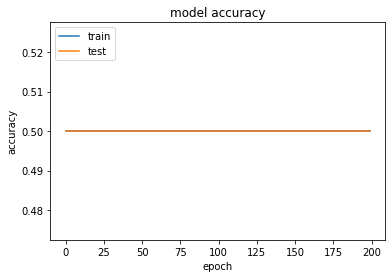

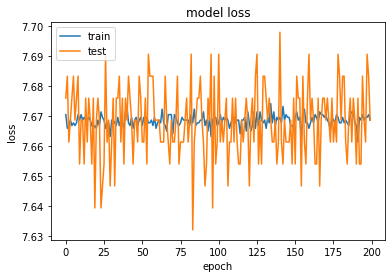

In [31]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [32]:
print(model.predict(test_ds))

1/1 [==============================] - 0s 96ms/step
[[0.99999994 0.        ]
 [0.99999994 0.        ]
 [0.99999994 0.        ]
 [0.99999994 0.        ]
 [0.99999994 0.        ]
 [0.99999994 0.        ]
 [0.99999994 0.        ]
 [0.99999994 0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]]


In [33]:
def print_accuracy(ds):
  predictions = model.predict(ds)
  predicted_labels = np.argmax(predictions, axis=1)
  true_values = np.concatenate([y for x, y in ds], axis=0)
  count = 0
  for i in range(len(predicted_labels)):
    if predicted_labels[i] == true_values[i]:
      count = count + 1
  print("The accuracy for given dataset is: ", count/len(predicted_labels)*100)
    

In [34]:
print_accuracy(test_ds)

1/1 [==============================] - 0s 9ms/step
The accuracy for given dataset is:  53.84615384615385


In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

1/1 [==============================] - 0s 6ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 0 0 0 1 1 0 0]


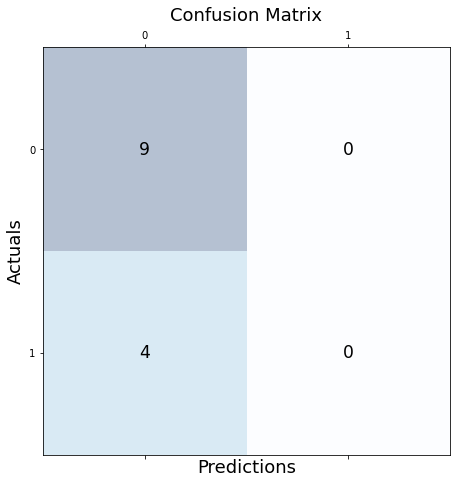

In [36]:
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)
true_values = np.concatenate([y for x, y in test_ds], axis=0)
print(true_values)
cm =confusion_matrix(true_values,predicted_labels,labels=[0, 1])
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()